In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

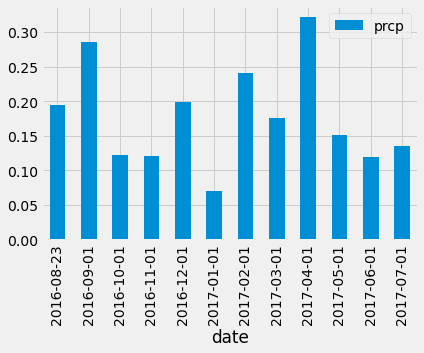

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
date_eof = session.query(measurement.date).order_by(measurement.date.desc()).first()
diff = dt.date(2017,8,23) - dt.timedelta(days=365)
#diff = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date,func.avg(measurement.prcp)]
last_year = session.query(*sel).\
    filter((measurement.date) > dt.date(2016,8,22)).\
    group_by(func.strftime('%m', measurement.date)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(last_year, columns=['date','prcp'])
last_year_df.set_index('date',inplace=True)

# Sort the dataframe by date
last_year_df = last_year_df.sort_values(by='date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
last_year_df.plot.bar()
plt.savefig("Images/MontlyAveraged.png")

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sel = [measurement.date,measurement.prcp]
raw_data = session.query(*sel).all()
raw_data_df = pd.DataFrame(raw_data, columns=['date','prcp'])
raw_data_df.describe()

,prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [12]:
# Design a query to show how many stations are available in this dataset?
station_num = session.query(station.station, func.count(station.station)).\
    group_by(station.station).all()
station_num

[('USC00511918', 1),
 ('USC00513117', 1),
 ('USC00514830', 1),
 ('USC00516128', 1),
 ('USC00517948', 1),
 ('USC00518838', 1),
 ('USC00519281', 1),
 ('USC00519397', 1),
 ('USC00519523', 1)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(station.station, func.count(station.station)).\
    group_by(station.station).\
    filter(measurement.station == station.station).\
    order_by(func.count(station.station).desc()).all()
print(f'Most Active Stations:')
print(active_stations)

# Station ('USC00519281', 2772) has the most and ('USC00518838', 511) least observations

Most Active Stations:
[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = active_stations[0][0]
most_active_station = session.query(measurement.station, station.name,
                                    func.max(measurement.tobs),
                                    func.min(measurement.tobs),
                                    func.round(func.avg(measurement.tobs))).group_by(station.name).\
                                    filter(measurement.station == most_active).all()
print(f"Most active stations'\n\
        ID: {most_active_station[0][0]}\n\
        Max Temp: {most_active_station[0][2]}\n\
        Min Temp: {most_active_station[0][3]}\n\
        Avg Temp: {most_active_station[0][4]}")

Most active stations'
        ID: USC00519281
        Max Temp: 85.0
        Min Temp: 54.0
        Avg Temp: 72.0


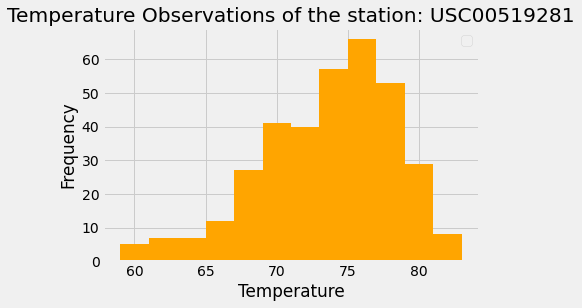

<Figure size 432x288 with 0 Axes>

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_temp = session.query(measurement.tobs).\
    filter(measurement.date >= dt.date(2016,8,23)).\
    filter(measurement.station==most_active).all()
high_temp

tobs = []
for temp in high_temp:
    tobs.append(temp[0])

plt.title("Temperature Observations of the station: USC00519281")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend("Temperature")
plt.hist(tobs, bins=12, color = 'orange')
plt.show()
plt.savefig("Images/Most_active_histogram.png")

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_1 = calc_temps('2012-02-28', '2012-03-05')
trip_df = pd.DataFrame(trip_1, columns=['TMIN','TAVG','TMAX'])

[(62.0, 69.57142857142857, 74.0)]

Text(0, 0.5, 'Temp')

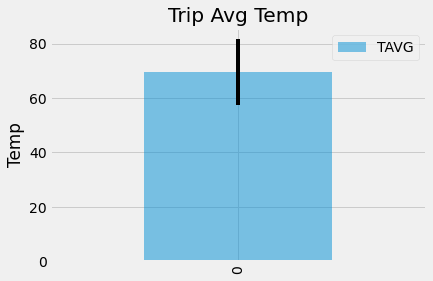

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df.plot.bar(y='TAVG', yerr=(trip_df['TMAX']-trip_df['TMIN']), title='Trip Avg Temp',alpha=0.5)
plt.ylabel('Temp')
plt.savefig('Images/TripTemperatureAverage.png')

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
